In [1]:
import cv2
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/srihari/vault/deep-learning-248814-a02166ece01f.json'
print('Tensorflow', tf.__version__)

Tensorflow 1.14.0


In [2]:
def imshow(image):
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(image)

def compute_anchor_dimensions(ratios=[0.5, 1, 2],
                              scales=[1, 1.25, 1.58],
                              areas=[32 * 32, 64 * 64, 128 * 128, 256 * 256, 512 * 512]):
    anchor_shapes = {'P{}'.format(i): [] for i in range(3, 8)}
    for area in areas:
        for ratio in ratios:
            a_h = np.sqrt(area / ratio)
            a_w = area / a_h
            for scale in scales:
                h = np.int32(scale * a_h)
                w = np.int32(scale * a_w)
                anchor_shapes['P{}'.format(
                    int(np.log2(np.sqrt(area) // 4)))].append([w, h])
        anchor_shapes['P{}'.format(int(np.log2(np.sqrt(area) // 4)))] = np.array(
            anchor_shapes['P{}'.format(int(np.log2(np.sqrt(area) // 4)))])
    return anchor_shapes

def get_anchors(input_shape=512, tensor=True):
    anchor_dimensions = compute_anchor_dimensions()
    anchors = []
    for i in range(3, 8):
        feature_name = 'P{}'.format(i)
        stride = 2**i
        feature_size = (input_shape) // stride

        dims = anchor_dimensions[feature_name]
        dims = dims[None, None, ...]
        dims = np.tile(dims, reps=[feature_size, feature_size, 1, 1])

        rx = (np.arange(feature_size) + 0.5) * (stride)
        ry = (np.arange(feature_size) + 0.5) * (stride)
        sx, sy = np.meshgrid(rx, ry)
        cxy = np.stack([sx, sy], axis=-1)
        cxy = cxy[:, :, None, :]
        cxy = np.tile(cxy, reps=[1, 1, 9, 1])
        anchors.append(np.reshape(
            np.concatenate([cxy, dims], axis=-1), [-1, 4]))
    anchors = np.concatenate(anchors, axis=0)
    if tensor:
        anchors = tf.constant(anchors, dtype=tf.float32)
    return anchors

@tf.function()
def compute_iou(boxes1, boxes2):
    boxes1 = tf.cast(boxes1, dtype=tf.float32)
    boxes2 = tf.cast(boxes2, dtype=tf.float32)

    boxes1_t = change_box_format(boxes1, return_format='x1y1x2y2')
    boxes2_t = change_box_format(boxes2, return_format='x1y1x2y2')

    lu = tf.maximum(boxes1_t[:, None, :2], boxes2_t[:, :2])
    rd = tf.minimum(boxes1_t[:, None, 2:], boxes2_t[:, 2:])

    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[:, :, 0] * intersection[:, :, 1]

    square1 = boxes1[:, 2] * boxes1[:, 3]
    square2 = boxes2[:, 2] * boxes2[:, 3]

    union_square = tf.maximum(
        square1[:, None] + square2 - inter_square, 1e-10)
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

def change_box_format(boxes, return_format='xywh'):
    boxes = tf.cast(boxes, dtype=tf.float32)
    if return_format == 'xywh':

        return tf.stack([(boxes[..., 2] + boxes[..., 0]) / 2.0,
                         (boxes[..., 3] + boxes[..., 1]) / 2.0,
                         boxes[..., 2] - boxes[..., 0],
                         boxes[..., 3] - boxes[..., 1]], axis=-1)
    elif return_format == 'x1y1x2y2':

        return tf.stack([boxes[..., 0] - boxes[..., 2] / 2.0,
                         boxes[..., 1] - boxes[..., 3] / 2.0,
                         boxes[..., 0] + boxes[..., 2] / 2.0,
                         boxes[..., 1] + boxes[..., 3] / 2.0], axis=-1)
    return 'You should not be here'

def draw_bboxes(image, bbox_list):
    image = image / 255.
    h, w = image.shape.as_list()[:2]
    bboxes = tf.cast(tf.stack([
        bbox_list[:, 1] / h, bbox_list[:, 0] /
        w, bbox_list[:, 3] / h, bbox_list[:, 2] / w
    ], axis=-1), dtype=tf.float32)

    colors = tf.random.uniform(maxval=1, shape=[bbox_list.shape[0], 3])
    return tf.image.convert_image_dtype(tf.image.draw_bounding_boxes(image[None, ...],
                                                                     bboxes[None, ...],
                                                                     colors)[0, ...], dtype=tf.uint8)

def draw_boxes_cv2(image, bbox_list):
    img = np.uint8(image).copy()
    bbox_list = np.array(bbox_list, dtype=np.int32)
    for box in bbox_list:
        img = cv2.rectangle(img, (box[0], box[1]),
                            (box[2], box[3]), [0, 0, 200], 2)
    return img

@tf.function
def random_image_augmentation(img):
    img = tf.image.random_brightness(img, max_delta=50.)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = tf.clip_by_value(img, 0, 255)
    return img

@tf.function
def get_image(image_path, input_shape=None):
    H = W = input_shape
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, size=[H, W])
    img = random_image_augmentation(img)
    img = img[:, :, ::-1] - tf.constant([103.939, 116.779, 123.68])
    return img

def load_data(input_shape=None):
    def load_data(image_path, label):
        images = get_image(image_path, input_shape=input_shape)
        targets = encode_targets(label, input_shape=input_shape)

        return images, targets
    return load_data

@tf.function
def encode_targets(label, input_shape=None):
    """We use the assignment rule from RPN.
        Faster RCNN box coder follows the coding schema described below:
            ty = (y - ya) / ha
            tx = (x - xa) / wa
            th = log(h / ha)
            tw = log(w / wa)
        where x, y, w, h denote the box's center coordinates, width and height
        respectively. Similarly, xa, ya, wa, ha denote the anchor's center
        coordinates, width and height. tx, ty, tw and th denote the
        anchor-encoded center, width and height respectively.
        The open-source implementation recommends using [10.0, 10.0, 5.0, 5.0] as
        scale factors.
        See http://arxiv.org/abs/1506.01497 for details. 
        Set achors with iou < 0.5 to 0 and
        set achors with iou iou > 0.4 && < 0.5 to -1. Convert
        regression targets into one-hot encoding (N, 
        in loss_fn and exclude background class in loss calculation.
        Use [0, 0, 0, ... 0, n_classes] (all units set to zeros) to represent
        background class.
    """
    scale_factors = tf.constant([10.0, 10.0, 5.0, 5.0])
    anchors = get_anchors(input_shape=input_shape, tensor=True)
    gt_boxes = label[:, :4]
    gt_boxes = change_box_format(gt_boxes, return_format='xywh')
    gt_class_ids = label[:, 4]
    ious = compute_iou(anchors, gt_boxes)

    max_ious = tf.reduce_max(ious, axis=1)
    max_ids = tf.argmax(ious, axis=1, output_type=tf.int32)

    background_mask = max_ious > 0.5
    ignore_mask = tf.logical_and(max_ious > 0.4, max_ious < 0.5)

    selected_gt_boxes = tf.gather(gt_boxes, max_ids)
    selected_gt_class_ids = 1. + tf.gather(gt_class_ids, max_ids)

    selected_gt_class_ids = selected_gt_class_ids * \
        tf.cast(background_mask, dtype=tf.float32)
    classification_targets = selected_gt_class_ids - tf.cast(
        ignore_mask, dtype=tf.float32)
    regression_targets = tf.stack([
        (selected_gt_boxes[:, 0] - anchors[:, 0]) / anchors[:, 2],
        (selected_gt_boxes[:, 1] - anchors[:, 1]) / anchors[:, 3],
        tf.math.log(selected_gt_boxes[:, 2] / anchors[:, 2]),
        tf.math.log(selected_gt_boxes[:, 3] / anchors[:, 3])
    ], axis=-1)
    regression_targets = regression_targets * scale_factors
    reg_zeros = tf.zeros_like(regression_targets)

    '''dirty hack to filter inf occuring during box encoding
    TODO - Handle objects with small area during tfrecord generation
    '''
    regression_targets = tf.where(tf.math.is_finite(regression_targets),
                                                regression_targets,
                                                reg_zeros)

    nan_losses_filter = tf.cast(tf.reduce_prod(tf.cast(tf.math.is_finite(regression_targets),
                                            dtype=tf.float32), axis=-1), dtype=tf.bool)
    background_mask = tf.logical_and(background_mask, nan_losses_filter)
    ignore_mask = tf.logical_and(ignore_mask, nan_losses_filter)
    return (tf.cast(classification_targets, dtype=tf.int32),
            regression_targets,
            background_mask,
            ignore_mask)

def conv_block(x,
               n_filters,
               size,
               strides=1,
               kernel_init='he_normal',
               bias_init='zeros',
               bn_activated=False, name=''):
    x = tf.keras.layers.Conv2D(filters=n_filters,
                               kernel_size=size,
                               padding='same',
                               strides=strides,
                               kernel_initializer=kernel_init,
                               bias_initializer=bias_init,
                               name='conv_' + name if name else None)(x)
    if bn_activated:
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
    return x

def Upsampling(tensor, scale=2):
    dims = tensor.shape.as_list()[1:-1]
    return tf.image.resize_bilinear(tensor, size=[dims[0] * scale, dims[1] * scale], align_corners=True)

def build_classification_subnet(n_classes=None, n_anchors=9, p=0.01):
    input_layer = tf.keras.layers.Input(shape=[None, None, 256])
    x = input_layer
    for i in range(4):
        x = conv_block(
            x, 256, 3, kernel_init=tf.keras.initializers.RandomNormal(0.0, 0.01))
        x = tf.keras.layers.ReLU()(x)
    bias_init = -np.log((1 - p) / p)
    output_layer = tf.keras.layers.Conv2D(filters=n_classes * n_anchors,
                                          kernel_size=3,
                                          padding='same',
                                          kernel_initializer=tf.keras.initializers.RandomNormal(
                                              0.0, 0.01),
                                          bias_initializer=tf.keras.initializers.Constant(
                                              value=bias_init),
                                          activation=None)(x)
    output_layer = tf.keras.layers.Reshape(
        target_shape=[-1, n_classes])(output_layer)
    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name='classification_subnet')

def build_regression_subnet(n_anchors=9):
    input_layer = tf.keras.layers.Input(shape=[None, None, 256])
    x = input_layer
    for i in range(4):
        x = conv_block(
            x, 256, 3, kernel_init=tf.keras.initializers.RandomNormal(0.0, 0.01))
        x = tf.keras.layers.ReLU()(x)
    output_layer = tf.keras.layers.Conv2D(filters=4 * n_anchors,
                                          kernel_size=3,
                                          padding='same',
                                          kernel_initializer=tf.keras.initializers.RandomNormal(
                                              0.0, 0.01),
                                          bias_initializer=tf.keras.initializers.zeros(),
                                          activation=None)(x)
    output_layer = tf.keras.layers.Reshape(
        target_shape=[-1, 4])(output_layer)
    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name='regression_subnet')

class LossV2():
    def __init__(self, batch_size=None, n_classes=None):
        self.num_classes = n_classes
        self.global_batch_size = batch_size
        self.smooth_l1 = tf.compat.v2.losses.Huber(delta=0.11, reduction='none')

    def focal_loss(self, y_true, y_pred, alpha=0.25, gamma=2):
        y_true = tf.one_hot(
            tf.cast(y_true, dtype=tf.int32), depth=self.num_classes + 1)
        y_true = y_true[:, :, 1:]
        y_pred_ = tf.sigmoid(y_pred)

        at = alpha * y_true + (1 - y_true) * (1 - alpha)
        pt = y_true * y_pred_ + (1 - y_true) * (1 - y_pred_)
        f_loss = at * tf.pow(1 - pt, gamma) * tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)

        return f_loss

    def smooth_l1_(self, y_true, y_pred, sigma=3.0):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        sigma = tf.cast(sigma, dtype=y_pred.dtype)
        x = y_true - y_pred
        abs_x = tf.abs(x)
        sigma_squared = tf.square(sigma)
        quadratic = 0.5 * tf.square(sigma * x)
        linear = abs_x - (0.5 / sigma_squared)
        smooth_l1_loss = tf.where(
            tf.less_equal(abs_x, 1. / sigma_squared), quadratic, linear)
        return smooth_l1_loss

    def __call__(self, tensor):
        classification_targets = tensor[0]
        classification_predictions = tensor[1]
        regression_targets = tensor[2]
        regression_predictions = tensor[3]
        background_mask = tensor[4]
        ignore_mask = tensor[5]

        background_mask = tf.cast(
            background_mask, dtype=tf.bool, name='bg_cast')
        ignore_mask = tf.cast(ignore_mask, dtype=tf.bool, name='ig_cast')

        num_positive_detections = tf.maximum(tf.reduce_sum(
            tf.cast(background_mask, dtype=tf.float32), axis=-1), 1.0)

        positive_classification_mask = tf.expand_dims(
            tf.logical_not(ignore_mask), axis=-1)
        positive_classification_mask = tf.tile(
            positive_classification_mask, multiples=[1, 1, self.num_classes])

        positive_regression_mask = tf.expand_dims(background_mask, axis=-1)
        positive_regression_mask = tf.tile(
            positive_regression_mask, multiples=[1, 1, 4])

        Lcls = self.focal_loss(classification_targets,
                               classification_predictions)
        Lreg = self.smooth_l1(regression_targets, regression_predictions)
        Lcls = Lcls * \
            tf.cast(positive_classification_mask, dtype=tf.float32)
        Lreg = Lreg * tf.cast(positive_regression_mask, dtype=tf.float32)

        Lcls = tf.reduce_sum(
            Lcls, axis=[1, 2]) / num_positive_detections
        Lreg = tf.reduce_sum(
            Lreg, axis=[1, 2]) / num_positive_detections

        Lcls = tf.reduce_mean(Lcls)
        Lreg = tf.reduce_mean(Lreg)
        return Lreg, Lcls, tf.reduce_mean(num_positive_detections)

In [3]:
class_map = {value: idx for idx, value in enumerate(['bus',
                                                     'traffic light',
                                                     'traffic sign',
                                                     'person',
                                                     'bike',
                                                     'truck',
                                                     'motor',
                                                     'car',
                                                     'train',
                                                     'rider'])}

INPUT_SHAPE = 640
BATCH_SIZE = 16
N_CLASSES = len(class_map)
EPOCHS = 200
training_steps = 70000 // BATCH_SIZE
val_steps = 10000 // BATCH_SIZE
LR = 1e-5 * 8

In [4]:
feature_description = {
    'image' : tf.io.FixedLenFeature([], tf.string),
    'xmins': tf.io.VarLenFeature(tf.float32),
    'ymins': tf.io.VarLenFeature(tf.float32),
    'xmaxs': tf.io.VarLenFeature(tf.float32),
    'ymaxs': tf.io.VarLenFeature(tf.float32),
    'labels': tf.io.VarLenFeature(tf.float32)
}

@tf.function
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    image_dims = tf.cast(tf.shape(image)[:2], dtype=tf.float32)[::-1]
    bboxes = tf.stack([
        tf.sparse_tensor_to_dense(parsed_example['xmins']),
        tf.sparse_tensor_to_dense(parsed_example['ymins']),
        tf.sparse_tensor_to_dense(parsed_example['xmaxs']),
        tf.sparse_tensor_to_dense(parsed_example['ymaxs'])
    ], axis=-1)
    class_ids = tf.reshape(tf.sparse_tensor_to_dense(parsed_example['labels']), [-1, 1])
    return image, bboxes, class_ids

@tf.function
def flip_data(image, boxes, w):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([
            w - boxes[:, 2],
            boxes[:, 1],
            w - boxes[:, 0],
            boxes[:, 3]
        ], axis=-1)
    return image, boxes

def load_data(input_shape):
    h, w = input_shape, input_shape

    @tf.function
    def load_data_(example_proto, input_shape=input_shape):
        image, boxes_, class_ids = parse_example(example_proto)
        image = tf.image.resize(image, size=[h, w])
        boxes = tf.stack([
            tf.clip_by_value(boxes_[:, 0] * w, 0, w),
            tf.clip_by_value(boxes_[:, 1] * h, 0, h),
            tf.clip_by_value(boxes_[:, 2] * w, 0, w),
            tf.clip_by_value(boxes_[:, 3] * h, 0, h)
        ], axis=-1)
        image, boxes = flip_data(image, boxes, w)
        label = tf.concat([boxes, class_ids], axis=-1)
        cls_targets, reg_targets, bg, ig = encode_targets(
            label, input_shape=input_shape)
        bg = tf.cast(bg, dtype=tf.float32)
        ig = tf.cast(ig, dtype=tf.float32)
        cls_targets = tf.cast(cls_targets, dtype=tf.float32)
        return (image, cls_targets, reg_targets, bg, ig), (tf.ones((1, )), tf.ones((1, )))
    return load_data_

train_files = tf.data.Dataset.list_files(
    'gs://srihari-datasets/BDD100k/train*')
train_dataset = train_files.interleave(tf.data.TFRecordDataset,
                                       cycle_length=16,
                                       block_length=16,
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(
    load_data(INPUT_SHAPE), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(
    BATCH_SIZE, drop_remainder=True).repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_files = tf.data.Dataset.list_files(
    'gs://srihari-datasets/BDD100k/validation*')
val_dataset = val_files.interleave(tf.data.TFRecordDataset,
                                   cycle_length=16,
                                   block_length=16,
                                   num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(
    load_data(INPUT_SHAPE), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

W0904 17:55:39.704457 4540847552 deprecation_wrapper.py:119] From /Users/srihari/tf2.0/lib/python3.6/site-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.sparse_tensor_to_dense is deprecated. Please use tf.sparse.to_dense instead.

W0904 17:55:41.526126 4540847552 deprecation.py:323] From /Users/srihari/tf2.0/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py:255: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
def RetinaNet(input_shape=None, n_classes=None, training=False):
    H = W = input_shape
    num_anchors = get_anchors(input_shape=H).shape[0]
    loss_fn = LossV2(batch_size=BATCH_SIZE, n_classes=N_CLASSES)

    base_model = tf.keras.applications.ResNet50(
        input_shape=[H, W, 3], weights=None, include_top=False)

    resnet_block_output_names = [
        'activation_21', 'activation_39', 'activation_48']

    resnet_block_outputs = {'C{}'.format(idx + 3): base_model.get_layer(
        layer).output for idx, layer in enumerate(resnet_block_output_names)}
    resnet_block_outputs = {level: conv_block(
        tensor, 256, 1, name=level + '_1x1') for level, tensor in resnet_block_outputs.items()}

    P5 = resnet_block_outputs['C5']
    P6 = conv_block(base_model.get_layer(
        'activation_48').output, 256, 3, strides=2, name='P6')
    P6_relu = tf.keras.layers.ReLU(name='P6')(P6)
    P7 = conv_block(P6_relu, 256, 3, strides=2, name='P7')
    M4 = tf.keras.layers.add([tf.keras.layers.Lambda(Upsampling, arguments={'scale': 2}, name='P5_UP')(
        P5), resnet_block_outputs['C4']], name='P4_merge')
    M3 = tf.keras.layers.add([tf.keras.layers.Lambda(Upsampling, arguments={'scale': 2}, name='P4_UP')(
        M4), resnet_block_outputs['C3']], name='P3_merge')
    P4 = conv_block(M4, 256, 3, name='P4')
    P3 = conv_block(M3, 256, 3, name='P3')
    pyrammid_features = [P7, P6, P5, P4, P3]

    classification_subnet = build_classification_subnet(
        n_classes=n_classes)
    regression_subnet = build_regression_subnet()

    classification_outputs = [classification_subnet(
        level) for level in pyrammid_features]
    regression_outputs = [regression_subnet(
        level) for level in pyrammid_features]

    classification_head = tf.keras.layers.concatenate(
        classification_outputs, axis=1, name='classification_head')
    regression_head = tf.keras.layers.concatenate(
        regression_outputs, axis=1, name='regression_head')

    image_input = base_model.input
    classification_targets = tf.keras.layers.Input(shape=[num_anchors])
    regression_targets = tf.keras.layers.Input(shape=[num_anchors, 4])
    background_mask = tf.keras.layers.Input(shape=[num_anchors])
    ignore_mask = tf.keras.layers.Input(shape=[num_anchors])

    Lreg, Lcls, _ = tf.keras.layers.Lambda(loss_fn)([classification_targets,
                                                     classification_head,
                                                     regression_targets,
                                                     regression_head,
                                                     background_mask,
                                                     ignore_mask])

    Lreg = tf.keras.layers.Lambda(
        lambda x: tf.reshape(x, [-1, 1]), name='box')(Lreg)
    Lcls = tf.keras.layers.Lambda(
        lambda x: tf.reshape(x, [-1, 1]), name='focal')(Lcls)

    if training:
        _inputs = [image_input, classification_targets,
                   regression_targets, background_mask, ignore_mask]
        _outputs = [Lreg, Lcls]
    else:
        _inputs = [image_input]
        _outputs = [classification_head, regression_head]
    return tf.keras.Model(inputs=_inputs, outputs=_outputs, name='RetinaNet')


model = RetinaNet(input_shape=INPUT_SHAPE,
                  n_classes=N_CLASSES, training=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR, clipnorm=0.001)

loss_dict = {
    'box': lambda x, y: y,
    'focal': lambda x, y: y
}
callback_list = [
    tf.keras.callbacks.TensorBoard(
        log_dir='gs://srihari-datasets/retinanet/logs', update_freq='epoch'),
    tf.keras.callbacks.ModelCheckpoint('gs://srihari-datasets/retinanet/weights',
                                       save_weights_only=True,
                                       save_best_only=True,
                                       monitor='loss',
                                       verbose=1)
]
model.compile(optimizer=optimizer, loss=loss_dict)
#     model.load_weights('gs://srihari-datasets/retinanet/imagenet_pretrained_weights/ckpt')

/Users/srihari/tf2.0/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
status = model.load_weights('model_files/retinanet_weights')

In [7]:
outputs_ = [model.get_layer(x).output for x in ['classification_head', 'regression_head']]
inference_model = tf.keras.Model(inputs=model.inputs[0], outputs=outputs_)

In [8]:
def decode_targets(classification_outputs,
                   regression_outputs,
                   input_shape=512,
                   classification_threshold=0.05,
                   nms_threshold=0.5):
    scale_factors = tf.constant([10.0, 10.0, 5.0, 5.0])
    anchors = get_anchors(input_shape=input_shape, tensor=True)

    class_ids = tf.argmax(classification_outputs, axis=-1)

    confidence_scores = tf.reduce_max(
        tf.nn.sigmoid(classification_outputs), axis=-1)
    regression_outputs = regression_outputs / scale_factors
    boxes = tf.concat([(regression_outputs[:, :2] * anchors[:, 2:] + anchors[:, :2]),
                       tf.math.exp(
                           regression_outputs[:, 2:]) * anchors[:, 2:]
                       ], axis=-1)
    boxes = change_box_format(boxes, return_format='x1y1x2y2')

    nms_indices = tf.image.non_max_suppression(boxes,
                                               confidence_scores,
                                               score_threshold=classification_threshold,
                                               iou_threshold=nms_threshold,
                                               max_output_size=100)
    final_class_ids = tf.gather(class_ids, nms_indices)
    final_scores = tf.gather(confidence_scores, nms_indices)
    final_boxes = tf.cast(tf.gather(boxes, nms_indices), dtype=tf.int32)

    matched_anchors = tf.gather(anchors, tf.where(
        confidence_scores > classification_threshold)[:, 0])
    matched_anchors = tf.cast(change_box_format(matched_anchors, return_format='x1y1x2y2'),
                              dtype=tf.int32)
    return final_boxes, final_class_ids, final_scores, matched_anchors

In [9]:
batch = list(val_dataset.take(1))
images = batch[0][0][0]

In [59]:
i = 3
cls_preds, reg_preds = inference_model.predict(images[i:i+1])
b, c, s, matched_anchors = decode_targets(cls_preds[0], reg_preds[0], input_shape=INPUT_SHAPE, classification_threshold=0.4)
s

<tf.Tensor: id=19695, shape=(4,), dtype=float32, numpy=array([0.92644507, 0.82101727, 0.8101791 , 0.7251561 ], dtype=float32)>

(array([7, 7, 7, 7]),
 array([0.92644507, 0.82101727, 0.8101791 , 0.7251561 ], dtype=float32))

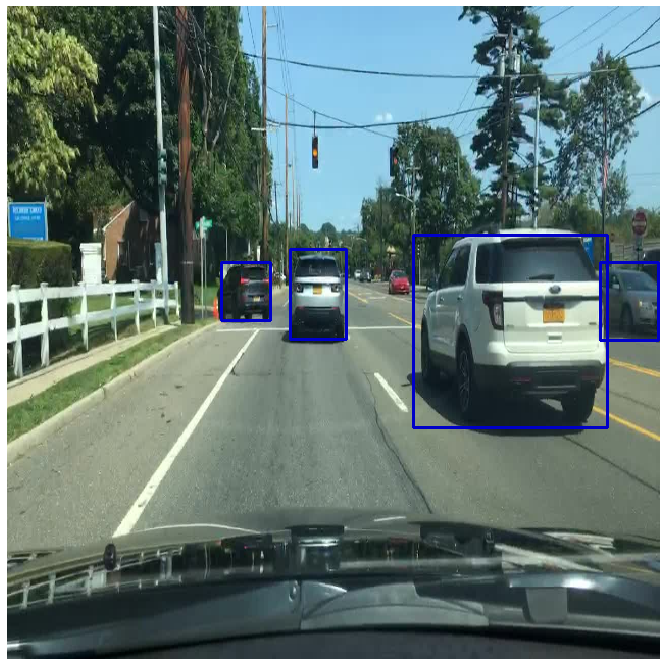

In [60]:
image = images[i]
image = draw_boxes_cv2(image, b)
imshow(image/255.)
c.numpy(), s.numpy()

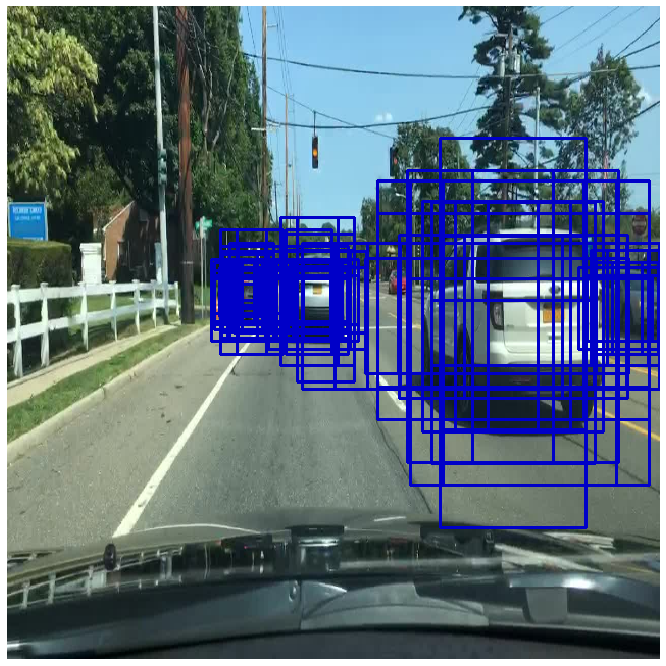

In [61]:
image = images[i]
image = draw_boxes_cv2(image, matched_anchors)
imshow(image/255.)